In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch

from tokeye.models.ae_tf_maskrcnn.config_ae_tf_maskrcnn import AETFMaskConfig
from tokeye.models.ae_tf_maskrcnn.model_ae_tf_maskrcnn import AETFMaskModel

In [3]:
def draw_boxes(ax, boxes, labels=None, scores=None, color='red', linewidth=2):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=linewidth,
            edgecolor=color,
            facecolor='none'
        )
        ax.add_patch(rect)

        if scores is not None:
            score = scores[i]
            ax.text(x1, y1 - 2, f'{score:.2f}', color=color, fontsize=8)


def draw_masks(ax, masks, alpha=0.5, cmap='jet'):
    if len(masks) == 0:
        return

    h, w = masks[0].shape
    combined = np.zeros((h, w, 4))  # RGBA

    colors = plt.get_cmap(cmap, len(masks))

    for i, mask in enumerate(masks):
        color = colors(i)
        mask_bool = mask > 0.5
        for c in range(3):
            combined[:, :, c] = np.where(mask_bool, color[c], combined[:, :, c])
        combined[:, :, 3] = np.where(mask_bool, alpha, combined[:, :, 3])

    ax.imshow(combined, origin='lower', aspect='auto')


In [67]:
ROOT_PATH = '/scratch/gpfs/nc1514/tokeye'
MODEL_FILE = 'mask_rcnn.pt'
DATA_FILE = 'eval/D3D2025/178632/spec/co2_density_v1.npy'

root_path = Path(ROOT_PATH)
model_path = root_path / 'model' / MODEL_FILE
data_path = root_path / 'data' / DATA_FILE

In [68]:
config = AETFMaskConfig()
state_dict = torch.load(model_path, weights_only=True)
model = AETFMaskModel(config)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded")

Model loaded


In [84]:
start_idx = 800
end_idx = start_idx + 710
spectrogram = np.load(data_path)
spectrogram = spectrogram[:,start_idx:end_idx]

In [85]:
mean = 54.63705062866211
std = 2.7319185733795166

In [86]:
model_input = spectrogram
model_input = torch.from_numpy(model_input)
model_input = model_input.unsqueeze(0).float()
model_input = (model_input - mean) / std

print(f'Shape: {model_input.shape}')
print(f'Datatype: {model_input.dtype}')
print(f'Mean: {model_input.mean()}, Std: {model_input.std()}')

Shape: torch.Size([1, 512, 710])
Datatype: torch.float32
Mean: -0.1973496377468109, Std: 0.7768980860710144


In [89]:
threshold = 0.5

with torch.no_grad():
    model_output = model([model_input])[0]

model_output = model_output
keep_idx = model_output['scores'] > threshold
model_output = {
    'boxes': model_output['boxes'][keep_idx].cpu().numpy(),
    'scores': model_output['scores'][keep_idx].cpu().numpy(),
    'masks': model_output['masks'][keep_idx].squeeze(1).cpu().numpy(),
}
print(len(model_output['boxes']))

26


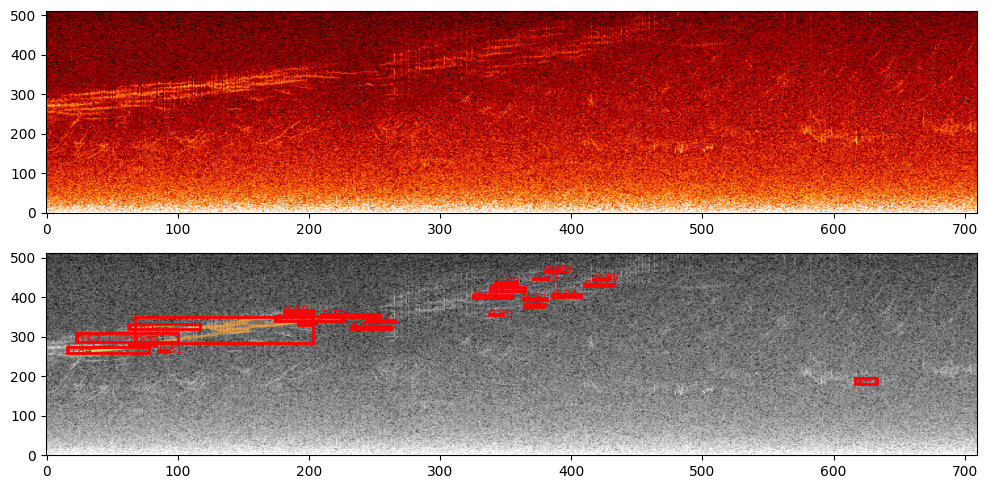

In [90]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

# Input
ax[0].imshow(
    spectrogram,
    aspect='auto',
    origin='lower',
    cmap='gist_heat',
)

# Model predictions
ax[1].imshow(spectrogram, cmap='gray', aspect='auto', origin='lower')

# Draw masks if available
if len(model_output['masks']) > 0:
    draw_masks(ax[1], model_output['masks'], alpha=0.5)

# Draw boxes
if len(model_output['boxes']) > 0:
    draw_boxes(
        ax[1],
        model_output['boxes'],
        scores=model_output['scores'],
        color='red',
        linewidth=2
    )

plt.tight_layout()
plt.show()